In this project, we'll be creating a gradient boosting (particularly XGBoost) regression model from scratch, and then comparing it to the implementation in the standard xgboost library. We'll be looking at the California housing dataset included with the sklearn datasets library.

In [2]:
import pandas as pd
from sklearn import datasets

housing = datasets.fetch_california_housing(as_frame=True)
df = housing['frame']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Let's take a look at the documentation for this dataset:

In [3]:
print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

We'll drop the Latitude and Longitude as features, and we'll try to preduct `MedHouseVal` as the target variable.

In [4]:
from sklearn.model_selection import train_test_split

# We shuffle the dataset to remove any ordering it might originally have
X_train, X_test, y_train, y_test = train_test_split(housing.data.drop(columns=['Latitude', 'Longitude']), housing.target, test_size=0.2, random_state=42, shuffle=True)

## Creating the model

We'll now create the XGBoost model from the underlying mathematical principles. One can consult the [original paper](https://arxiv.org/pdf/1603.02754) for all the details.

First, we'll be using the usual MSE loss function for XGBoost regressors,
$$L(y_i, \hat{y}_i) = \frac{1}{2} (y_i - \hat{y}_i)^2$$
where $y_i$ is the true label for the $i$-th sample and $\hat{y}_i$ the predicted value.

The goal is to minimize the objective function with $n$ samples
$$\text{obj} = \sum_{i = 1}^n L(y_i, \hat{y}_i) + \sum_{k = 1}^n \Omega(f_k)$$

where
$$\Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j = 1}^T w_j^2$$
is our regularization term with $f_k$ the $k$-th tree, $\gamma$ and $\lambda$ definable hyperparameters, $T$ the number of leaves in the tree, and the $w$'s the leaf weights.

We shall not run through all of the mathematics here, as there are plenty of resources online which already do so, but one finds that the objective function is minimized when
$$w_j = -\frac{\text{Sum of residuals}}{\text{Number of residuals} + \lambda}$$

In [5]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class XGBoost:
    def __init__(self, n_estimators=100, learning_rate=0.3, max_depth=6, alpha=0, gamma=0, reg_lambda=1):       # Defaulting the hyperparameters to match the ones for the usual XGBoost library
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.alpha = alpha          # L1 regularization. Not used in this implementation
        self.gamma = gamma
        self.reg_lambda = reg_lambda
        self.models = []

    def calculate_gradient(self, y, y_pred):
        # Gradient of the loss function with respect to predictions
        return y_pred - y

    def calculate_hessian(self, y, y_pred):
        # Hessian of the loss function with respect to predictions (is constant here)
        return np.ones_like(y)

    def fit_tree(self, X, gradient, hessian):
        tree = DecisionTreeRegressor(max_depth=self.max_depth, min_impurity_decrease=self.gamma)
        # XGBoost minimizes negative gradient
        tree.fit(X, -gradient / (hessian + self.reg_lambda))
        return tree

    def fit(self, X, y):
        # Initialize predictions to the mean
        mean_y = np.mean(y)
        y_pred = np.full_like(y, mean_y)

        # Iterate over the specified number of boosting rounds
        for i in range(self.n_estimators):
            gradient = self.calculate_gradient(y, y_pred)
            hessian = self.calculate_hessian(y, y_pred)
            tree = self.fit_tree(X, gradient, hessian)
            self.models.append(tree)
            # Update predictions by adding the predictions of the newly trained tree with a scaled learning rate
            y_pred += self.learning_rate * tree.predict(X)

    def predict(self, X):
        # Initialize predictions with the mean of training labels
        y_pred = np.full(len(X), np.mean([tree.predict(X) for tree in self.models]))
        
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

## Evaluating the model

Now let's put it to the test.

In [6]:
from sklearn.metrics import mean_squared_error

learning_rates = [x / 10 for x in range(1, 11)]
performance_scores = {'MSE': []}

for i in learning_rates:
    model = XGBoost(learning_rate=i)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    performance_scores['MSE'].append(mse)

In [7]:
performance_scores

{'MSE': [4.722900894671781,
  4.715654896847849,
  4.706863062767819,
  4.693940088917427,
  4.707368092631065,
  4.713038209457979,
  4.720893435190545,
  4.71460040736235,
  4.716041208880908,
  4.739320579546301]}

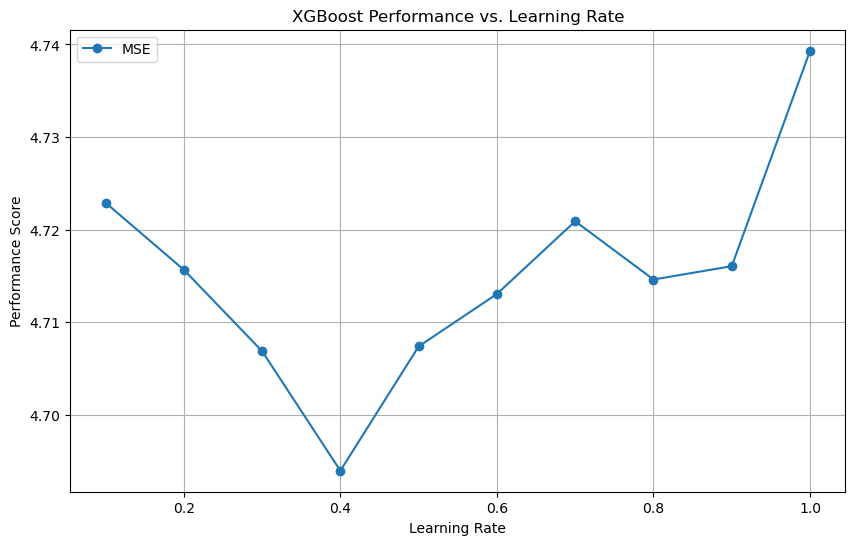

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for metric, scores in performance_scores.items():
    plt.plot(learning_rates, scores, marker='o', label=metric)
plt.xlabel('Learning Rate')
plt.ylabel('Performance Score')
plt.title('XGBoost Performance vs. Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

## Comparison with standard XGBoost implementation

Let's see how the standard implementation performs on the same dataset.

In [9]:
import xgboost as xgb

performance_scores_xgb = {'MSE': []}

for i in learning_rates:
    model_xgb = xgb.XGBRegressor(learning_rate=i)
    model_xgb.fit(X_train, y_train)
    predictions_xgb = model_xgb.predict(X_test)
    
    mse_xgb = mean_squared_error(y_test, predictions_xgb)
    performance_scores_xgb['MSE'].append(mse_xgb)

In [10]:
performance_scores_xgb

{'MSE': [0.41209526855158063,
  0.42471734400543454,
  0.43084987042362394,
  0.4664803923805653,
  0.4728320218428395,
  0.5033125015487387,
  0.5412595937150858,
  0.5635785646556952,
  0.6116679278577715,
  0.6411343665169797]}

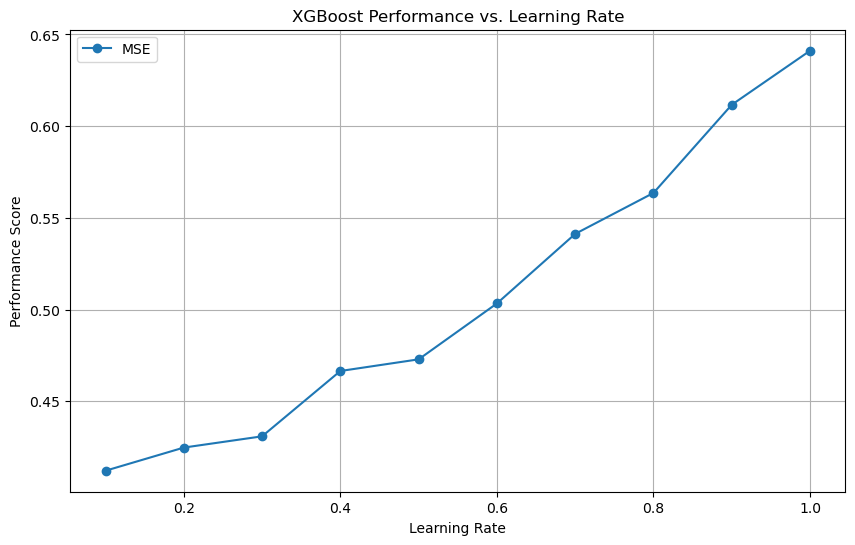

In [11]:
plt.figure(figsize=(10, 6))
for metric, scores in performance_scores_xgb.items():
    plt.plot(learning_rates, scores, marker='o', label=metric)
plt.xlabel('Learning Rate')
plt.ylabel('Performance Score')
plt.title('XGBoost Performance vs. Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

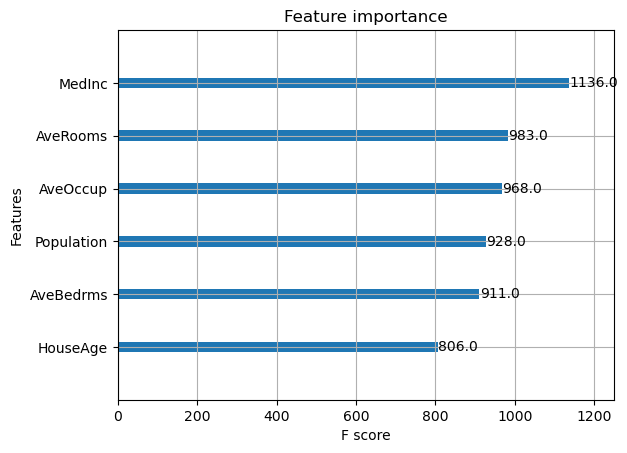

In [14]:
xgb.plot_importance(model_xgb);

As we can see, it appears the standard implementation of XGBoost is far better than ours. This is likely due to the various optimizations that are baked into the more feature-filled model. If we wanted to, for fun, we can play around with the hyperparameters and use performance scores other than MSE, but we shall end the project here.